# PTM with 6 strain rates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("mime")
import h5py
from scipy.optimize import curve_fit
import lmfit

colors = ['#bb0000', '#00bb00', "#0000bb", '#bbbb00', '#bb00bb', "#00bbbb", '#bbbbbb', '#770000', '#007700', "#000077", '#777700', '#770077', "#007777", '#777777', '#440000', '#004400', "#000044", '#444400', '#440044', "#0044444", '#444444','#000000']

In [2]:
baseSize = (8, 6)  # Base size of a subplot

def sbPlot(n):
    if (n == 1): return 1, 1
    if (n <= 2): return 1, 2
    if (n <= 4): return 2, 2
    if (n <= 6): return 3, 2
    if (n <= 9): return 3, 3
    if (n <= 12): return 4, 3
    return 0, 0

def sbPlotSize(n):
    x, y = sbPlot(n)
    return baseSize[0] * y, baseSize[1] * x

In [3]:
h5f = h5py.File('../GleebleData.h5','r')
allData = h5f['all'][:]
shortData = h5f['short'][:]
h5f.close()

In [4]:
allData.shape, shortData.shape

((21030, 4), (1080, 4))

Remove first point of each curve, where $\varepsilon^p=0$

In [5]:
#identData = allData[allData[:,0] != 0]
identData = shortData[shortData[:,0]!=0]

In [6]:
strains = np.unique(identData[:,0])
allStrains = np.unique(allData[:,0])
epsps = np.unique(identData[:,1])
temperatures = np.unique(identData[:,2])
nEps = len(strains)
nEpsp = len(epsps)
nTemp = len(temperatures)
#strains, epsps, temperatures, nEps, nEpsp, nTemp

# Identification of the PTM parameters
$$\sigma^y(\varepsilon^p,\dot\varepsilon,T) = \left(\sum_{i=0}^{q}{A_i\varepsilon^{p^i}}\right) \exp\left[\left(\sum_{j=0}^{r}{B_j\varepsilon^{p^j}}\right)\left(T-T_0\right) + \left(\sum_{k=0}^{s}\left(\sum_{l=0}^{t}{C_k^l\varepsilon^{p^l}} \right)\left(T-T_0\right)^k \right)\ln\left( \frac{\dot\varepsilon}{\dot{\varepsilon}_0}\right)\right]$$

In [7]:
T0 = temperatures[0]
epsp0 = epsps[0]
Tm = 1460
q=5
r=5
s=1
t=5

In [8]:
def genParams(params, label, order, srange=None):
    for i in range(order+1):
        if srange == None :
            params.add(label+str(i), value=0)
        else:
            params.add(label+str(i), value=0, min=-srange, max= +srange)

In [9]:
def polyFunc(eps, opt):
    res = 0
    i = 0
    for k in opt.keys():
        res += opt[k]*eps**i
        i += 1
    return res

In [10]:
refSRdata = identData[identData[:,1]==epsp0]
comSig = np.concatenate((refSRdata, np.log(refSRdata[:,3].reshape(refSRdata[:,3].shape[0], 1))), axis=1)

In [11]:
def constitutiveLaw(T, I1, S1):
    return I1 + S1*T 

In [12]:
I1 = []
S1 = []
for i in list(strains):
    sbdata = comSig[comSig[:,0]==i]
    popt, pcov = curve_fit(constitutiveLaw, sbdata[:,2]-T0, sbdata[:,4])
    I_i, S_i = popt
    I1.append(I_i)
    S1.append(S_i)
J = np.exp(I1)

In [13]:
AI = lmfit.Parameters()
genParams(AI, 'A', q)

def objA(opt):
    return J - polyFunc(strains, opt)

fitA = lmfit.minimize(objA, AI)
fitA.params

name,value,standard error,relative error,initial value,min,max,vary
A0,16.8528656,0.46943560,(2.79%),0,-inf,inf,True
A1,340.645124,12.5130307,(3.67%),0,-inf,inf,True
A2,-1959.40416,103.985839,(5.31%),0,-inf,inf,True
A3,4835.96990,360.342717,(7.45%),0,-inf,inf,True
A4,-5517.60941,548.604679,(9.94%),0,-inf,inf,True
A5,2405.83995,303.365043,(12.61%),0,-inf,inf,True


In [14]:
BI = lmfit.Parameters()
genParams(BI, 'B', r)

def objB(opt):
    return S1 - polyFunc(strains, opt) 

fitB = lmfit.minimize(objB, BI)
fitB.params

name,value,standard error,relative error,initial value,min,max,vary
B0,-0.00354184,2.1953e-04,(6.20%),0,-inf,inf,True
B1,-0.01317760,0.00585161,(44.41%),0,-inf,inf,True
B2,-0.00448880,0.04862813,(1083.32%),0,-inf,inf,True
B3,0.22179440,0.16851150,(75.98%),0,-inf,inf,True
B4,-0.49884483,0.25655087,(51.43%),0,-inf,inf,True
B5,0.32110014,0.14186640,(44.18%),0,-inf,inf,True


In [15]:
def indenfunctionS2(t, S2):
    return S2*t 

In [16]:
C0 = []
C1 = []
for i in list(strains):
    sbdata = identData[identData[:,0]==i]
    S2 = []
    for j in list(temperatures):
        sbdata1 = sbdata[sbdata[:,2]==j]
        sig_j = np.log(sbdata1[:,3]) - np.log(polyFunc(i, fitA.params)) - polyFunc(i, fitB.params) * (j - T0)
        popt, pcov = curve_fit(indenfunctionS2, np.log(sbdata1[:,1]/epsp0), sig_j)
        S_j = popt
        S2.append(S_j)
    S2_params = np.polyfit(temperatures-T0, S2, 1)
    y25, y24 = S2_params
    C0.append(y24[0])
    C1.append(y25[0])

In [17]:
C0I = lmfit.Parameters()
genParams(C0I, 'C0', t)

def objC0(opt):
    return C0 - polyFunc(strains, opt)

fitC0 = lmfit.minimize(objC0, C0I)
fitC0.params

name,value,standard error,relative error,initial value,min,max,vary
C00,0.16076739,7.5681e-04,(0.47%),0,-inf,inf,True
C01,-0.62016384,0.02017307,(3.25%),0,-inf,inf,True
C02,4.95156737,0.16764233,(3.39%),0,-inf,inf,True
C03,-13.1693638,0.58093195,(4.41%),0,-inf,inf,True
C04,15.2499943,0.88444136,(5.80%),0,-inf,inf,True
C05,-6.58698503,0.48907457,(7.42%),0,-inf,inf,True


In [18]:
C1I = lmfit.Parameters()
genParams(C1I, 'C1', t)

def objC1(opt):
    return C1 - polyFunc(strains, opt)

fitC1 = lmfit.minimize(objC1, C1I)
fitC1.params

name,value,standard error,relative error,initial value,min,max,vary
C10,-1.9037e-05,3.2388e-06,(17.01%),0,-inf,inf,True
C11,0.00266997,8.6333e-05,(3.23%),0,-inf,inf,True
C12,-0.00357881,7.1745e-04,(20.05%),0,-inf,inf,True
C13,-0.02223877,0.00248617,(11.18%),0,-inf,inf,True
C14,0.06086692,0.00378508,(6.22%),0,-inf,inf,True
C15,-0.04128814,0.00209306,(5.07%),0,-inf,inf,True


In [19]:
def PTMLaw(eps, epsp, T):
    return polyFunc(eps, fitA.params) * np.exp(polyFunc(eps, fitB.params)*(T - T0) + (polyFunc(eps, fitC0.params) + polyFunc(eps, fitC1.params)*(T-T0)) * np.log(epsp/epsp0))

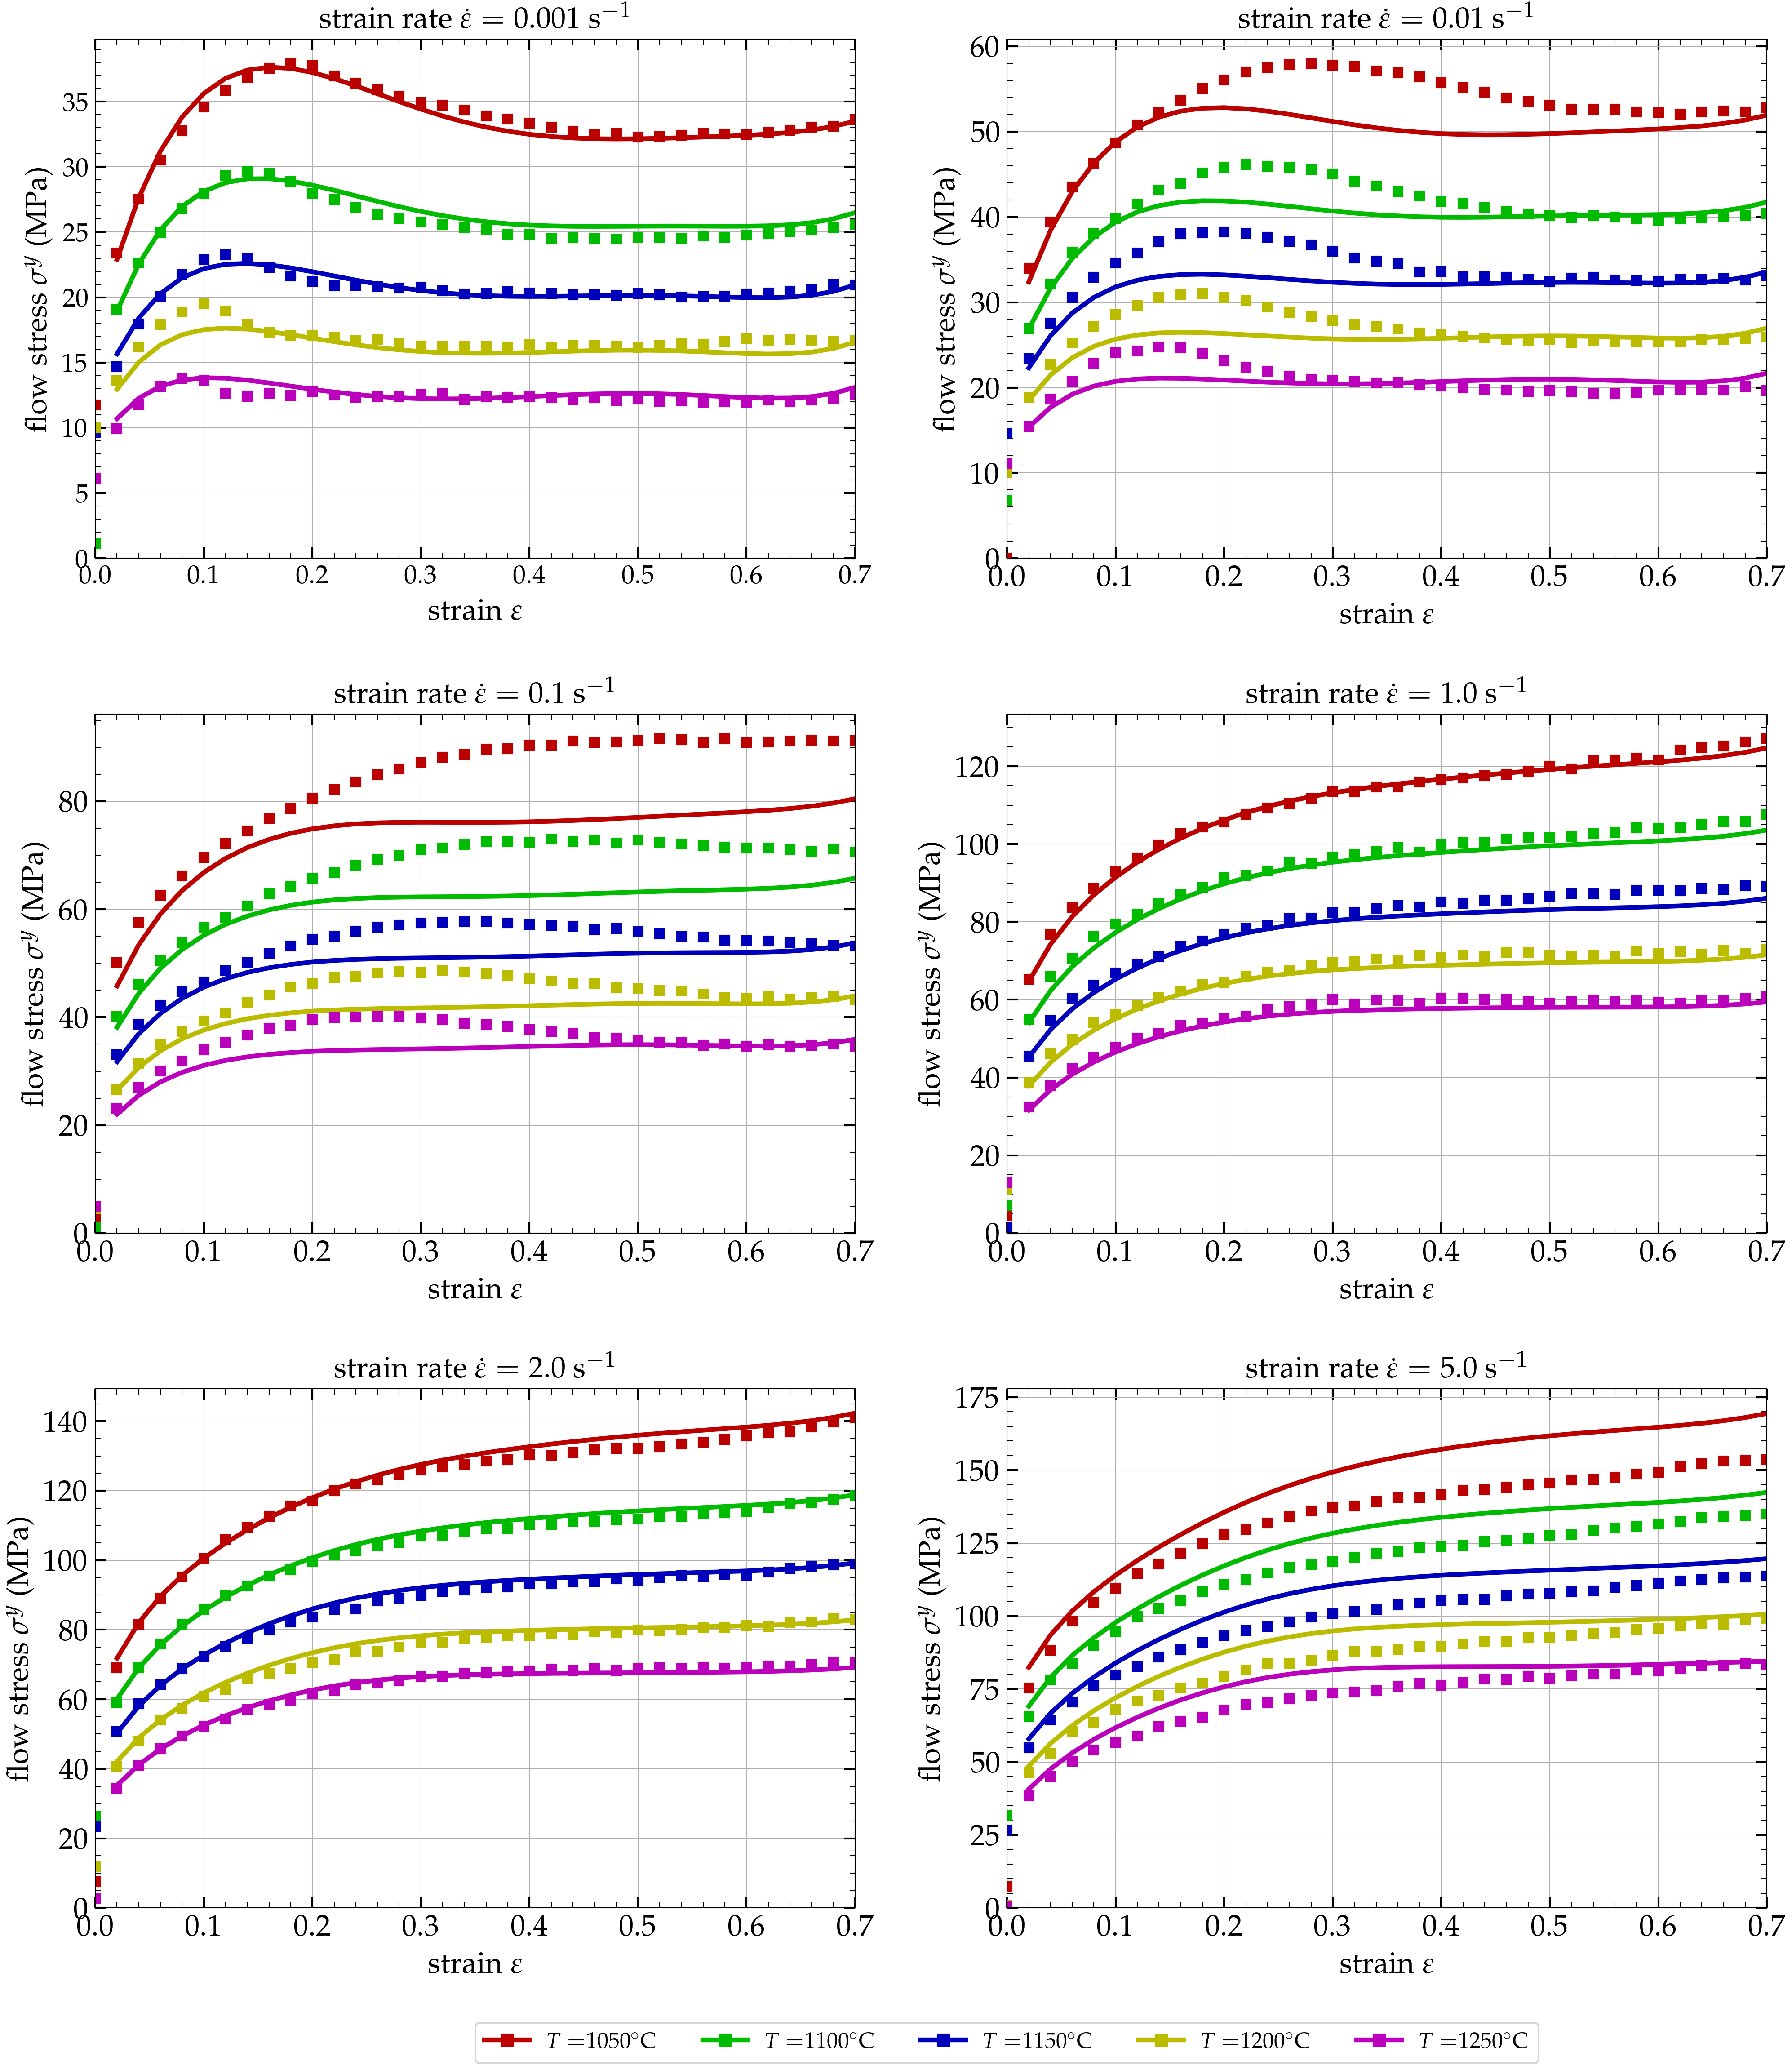

In [20]:
# Plot the curves
from matplotlib.lines import Line2D
def create_dummy_line(**kwds):
    return Line2D([], [], **kwds)

plt.figure(figsize = sbPlotSize(nEpsp))
plt.rc('text', usetex = True)
idx = 1
plt.subplots_adjust(hspace = 0.3)
for epsp in list(epsps):
    xs, ys = sbPlot(nEpsp)
    plt.subplot(xs, ys, idx)
    sbdata = shortData[shortData[:,1]==epsp]
    cl =0
    for temp in list(temperatures):
        sbdata1 = sbdata[sbdata[:,2]==temp]
        plt.plot(sbdata1[:,0], sbdata1[:,3], colors[cl], marker = 's', markersize = 5, linestyle = 'none')
        plt.plot(strains, PTMLaw(strains, epsp, temp), colors[cl], linewidth = 2.5)
        plt.rcParams['xtick.labelsize'] = 16
        plt.rcParams['ytick.labelsize'] = 16
        cl +=1
    plt.xlim(0, 0.7)
    plt.ylim(bottom=0)
    plt.xlabel(r'strain $\varepsilon$', fontsize = 16) # Labels the x axis
    plt.ylabel(r'flow stress $\sigma^y$ (MPa)', fontsize = 16) # Labels the y axis
    plt.title(r'strain rate $\dot{\varepsilon} = ' + str(epsp) + '$ s$^{-1}$', fontsize = 16) # Self explicit command
    idx += 1
    
legendLines = []
cl = 0
for temp in list(temperatures):
    legendLines.append((r'$T=$' + str(int(temp)) + r'$^{\circ}$C', {'color':colors[cl], 'linestyle':'-', 'linewidth':2.5, 'marker':'s'}))
    cl += 1

plt.legend([create_dummy_line(**l[1]) for l in legendLines],[l[0] for l in legendLines], 
           loc = 'upper center', fontsize = 12, ncols = 5, bbox_to_anchor = (0.0, -0.2), shadow = False)

plt.savefig("CompExpPTM.svg")
plt.show()

In [21]:
ARstress = PTMLaw(identData[:,0], identData[:,1], identData[:,2])

In [22]:
EAAR = np.sum(np.abs((identData[:,3] - ARstress)/(identData[:,3])))*100/ARstress.shape[0]
print("EAAR = %g" %(EAAR) + ' %')

EAAR = 4.52943 %


In [23]:
RMSE = np.sqrt(np.sum((identData[:,3] - ARstress)**2)/ARstress.shape[0])
print('RMSE = %g' %(RMSE)+' MPa')

RMSE = 4.54665 MPa


In [24]:
import math

def truncate(number, decimals=0):
    """
    Returns a value truncated to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.trunc(number)

    factor = 10.0 ** decimals
    return math.trunc(number * factor) / factor

l1=list(fitA.params.values())
l2=list(fitB.params.values())
l3=list(fitC0.params.values())
l4=list(fitC1.params.values())
for i in range(10):
    s = ''
    if i < (len(l1)):
        s += l1[i].name+'='+ str(truncate(l1[i].value,4))
    s+=' & '
    if i < (len(l2)):
        s += l2[i].name+'='+ str(truncate(l2[i].value,4))
    s+=' & '
    if i < (len(l3)):
        s += l3[i].name+'='+ str(truncate(l3[i].value,4))
    s+=' & '
    if i < (len(l4)):
        s += l4[i].name+'='+ str(truncate(l4[i].value,4))
    s+='\\\\'    
    print(s)

A0=16.8528 & B0=-0.0035 & C00=0.1607 & C10=0.0\\
A1=340.6451 & B1=-0.0131 & C01=-0.6201 & C11=0.0026\\
A2=-1959.4041 & B2=-0.0044 & C02=4.9515 & C12=-0.0035\\
A3=4835.9698 & B3=0.2217 & C03=-13.1693 & C13=-0.0222\\
A4=-5517.6094 & B4=-0.4988 & C04=15.2499 & C14=0.0608\\
A5=2405.8399 & B5=0.3211 & C05=-6.5869 & C15=-0.0412\\
 &  &  & \\
 &  &  & \\
 &  &  & \\
 &  &  & \\
